# Preparation

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [2]:

def viz_grid_filters(output, ncols=4, nrows=4):
    f_min, f_max = output.min(), output.max()
    output = (output - f_min) / (f_max - f_min)
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6,6))
    # itertools.product creates a permutation 
    for idx, ax_idx in enumerate(list(itertools.product(range(ncols), range(nrows)))):
        ax[ax_idx[1], ax_idx[0]].imshow(output[0,:,:,idx])

# Visualize filters of ONE feature map (I didn't save the old ver...)
def old_filter_grid(filters, feature_map_idx=0):
    n_filters = len(filters[0,0,0,:])
    ix=1
    fig = plt.figure(figsize=(15,10))
    for i in range(n_filters):
        # get the output shape of each filter
        # f = filters[height, width, input_shape, output_shape]
        # f = (3,3, 16)
        f = filters[:,:,:,i]
        
        # 3 is the width
        for j in range(3):
            plt.subplot(n_filters,3,ix)
            plt.imshow(f[:,:,j])
            ix+=1
    plt.show()
    
# Visualize filters of ONE feature map
def filter_grid(filters, feature_map_idx=0):
    fig = plt.figure(figsize=(1,1))
    f = filters[:,:,:,feature_map_idx]
    
    # This plots one of the filters of the selected feature map
    # NOTE: This actually shows the last filter for the selected feature map
    for i in range(len(f[0,0,:])):
        plt.imshow(f[:,:,i])


# Visualize filters of ONE feature map
def new_filter_grid(filters, norm_filters, feature_map_idx=0, fig_size=(6,6)):
    f = filters[:,:,:,feature_map_idx]
    nf = norm_filters[:,:,:,feature_map_idx]
    filter_count = len(f[0,0,:])
    rows, cols = get_factors(filter_count)
    fig, axs = plt.subplots(rows, cols, figsize=fig_size)
    
    if rows == 1:
        for idx in range(cols):
            if idx < filter_count:
                axs[idx].imshow(f[:,:,idx])
                for i in range(3):
                    for j in range(3):
                        if nf[j,i,idx] < 0.65:
                            axs[idx].text(i,j,s=np.round(f[j,i,idx], 2), va='center', ha='center',color='white', weight='bold')
                        else:
                            axs[idx].text(i,j,s=np.round(f[j,i,idx], 2), va='center', ha='center',color='black', weight='bold')
    else:
        for idx, ax_idx in enumerate(itertools.product(range(rows),range(cols))):
            if idx < filter_count:
                axs[ax_idx].imshow(f[:,:,idx])
                for i in range(3):
                    for j in range(3):
                        if nf[j,i,idx] < 0.65:
                            axs[ax_idx].text(i,j,s=np.round(f[j,i,idx], 2), va='center', ha='center',color='white', weight='bold')
                        else:
                            axs[ax_idx].text(i,j,s=np.round(f[j,i,idx], 2), va='center', ha='center',color='black', weight='bold')
    plt.show()

# For Dynamic Plotting
def get_factors(num):
    factors = []
    for i in range(1,num):
        if num % i == 0:
            quo = int(num / i)
            if quo in factors or i in factors:
                break
            factors.append(i)
            factors.append(quo)
    factors.sort()
    return factors[int(len(factors)/2) - 1], factors[int(len(factors)/2)]

# Selected Road Classifier

In [3]:
model_path = "C:\\Users\\user\\Documents\\Machine-Learning-Hub-1\\Tensorflow\\kaggle_converted\\Final-B4_0_1-converted.keras"
saved_model = tf.keras.models.load_model(model_path)

In [4]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 16)      64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0

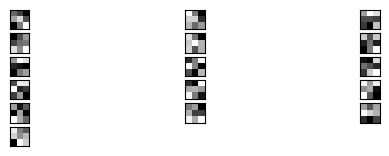

In [5]:
filters, biases = saved_model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()

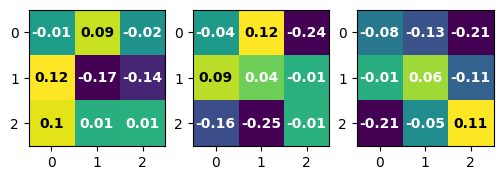

[[-0.01002858  0.09241674 -0.02323379]
 [ 0.11661131 -0.17051968 -0.14129308]
 [ 0.10485043  0.01023231  0.01119953]]


In [6]:
filters , bias = saved_model.layers[2].get_weights()
f_min, f_max = filters.min(), filters.max()
norm_filters = (filters - f_min) / (f_max - f_min)
new_filter_grid(filters, norm_filters, 0, (6,6))

ff = filters[:,:,:,0]
print(ff[:,:,0])

In [7]:
# 4th dimension refers to the number of feature maps that will be created
# 3rd dimension refers to the number of channels a feature map will use
# 1st and 2nd   refers to the matrix of a channel

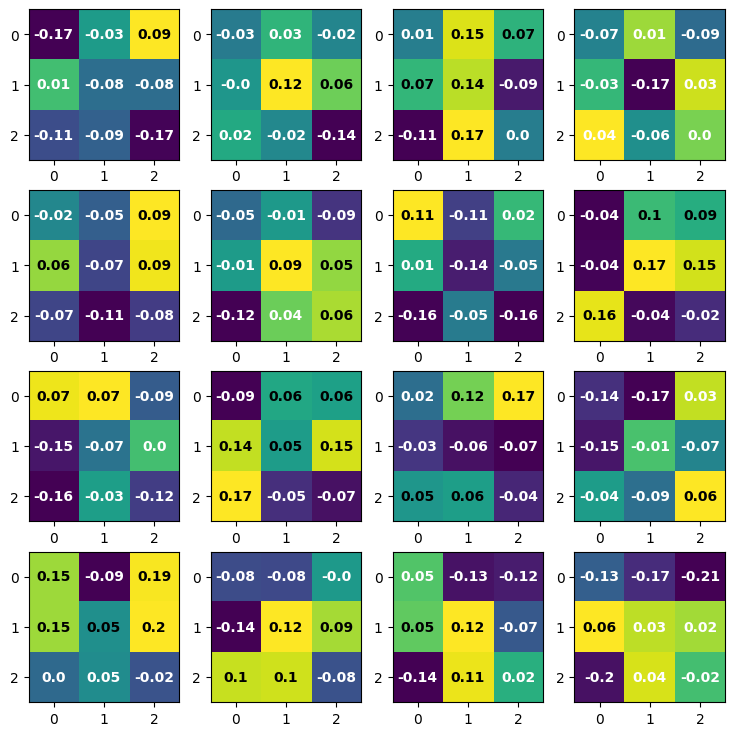

In [8]:
filters , bias = saved_model.layers[6].get_weights()
f_min, f_max = filters.min(), filters.max()
norm_filters = (filters - f_min) / (f_max - f_min)
new_filter_grid(filters, norm_filters, 0, (9,9))

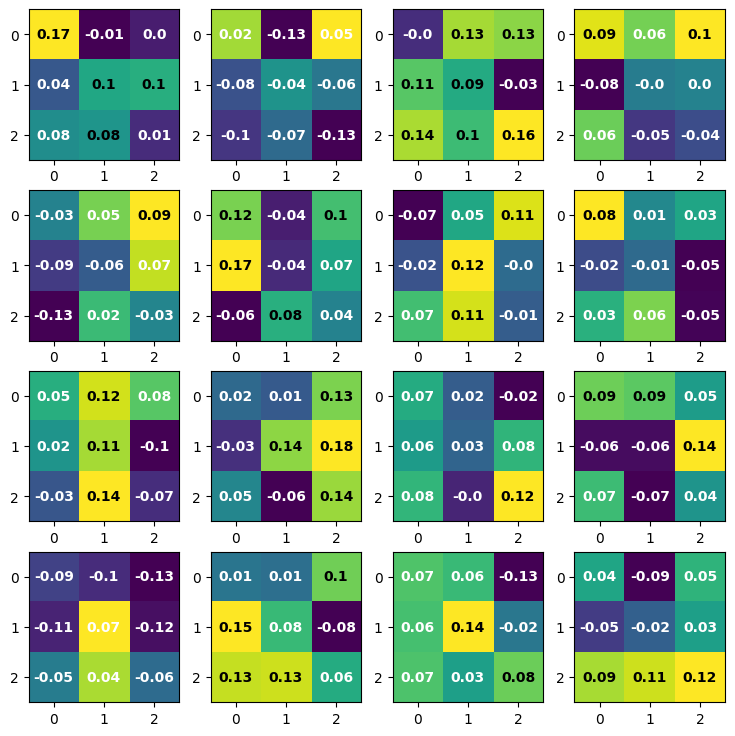

In [9]:
filters , bias = saved_model.layers[10].get_weights()
f_min, f_max = filters.min(), filters.max()
norm_filters = (filters - f_min) / (f_max - f_min)
new_filter_grid(filters, norm_filters, 0, (9,9))

In [10]:
filters[0][0][0]

array([ 0.17014103, -0.00861549, -0.06523962, -0.08247595, -0.00658276,
        0.00410664,  0.16489612, -0.0588625 ,  0.00492423, -0.03783556,
        0.02727088,  0.03419517, -0.12322345, -0.09813671,  0.00970003,
       -0.02892408, -0.08556718,  0.01277675, -0.07400025, -0.02847354,
        0.08402396, -0.03111871, -0.03997662, -0.02351562,  0.04022205,
       -0.11986334,  0.0453505 ,  0.10465103,  0.00687379,  0.15660772,
       -0.04025862,  0.12506106], dtype=float32)

# Selected Issue Classifier

In [11]:
model_path = "C:\\Users\\user\\Documents\\Machine-Learning-Hub-1\\Exp-Flask-New-Thesis\\model\\INI\\Final-Adr-INI-5_1_1-converted.keras"
saved_model = tf.keras.models.load_model(model_path)

In [12]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 16)      64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0

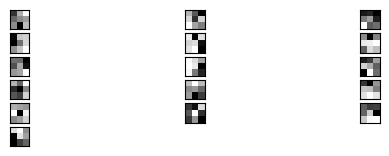

In [13]:
filters, biases = saved_model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()

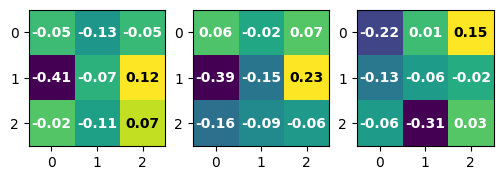

[[-0.04508715 -0.12888356 -0.04946014]
 [-0.41146347 -0.06819108  0.12307063]
 [-0.02001035 -0.10688969  0.07409651]]


In [14]:
filters , bias = saved_model.layers[2].get_weights()
f_min, f_max = filters.min(), filters.max()
norm_filters = (filters - f_min) / (f_max - f_min)
new_filter_grid(filters, norm_filters, 0, (6,6))

ff = filters[:,:,:,0]
print(ff[:,:,0])

In [15]:
# 4th dimension refers to the number of feature maps that will be created
# 3rd dimension refers to the number of channels a feature map will use
# 1st and 2nd   refers to the matrix of a channel

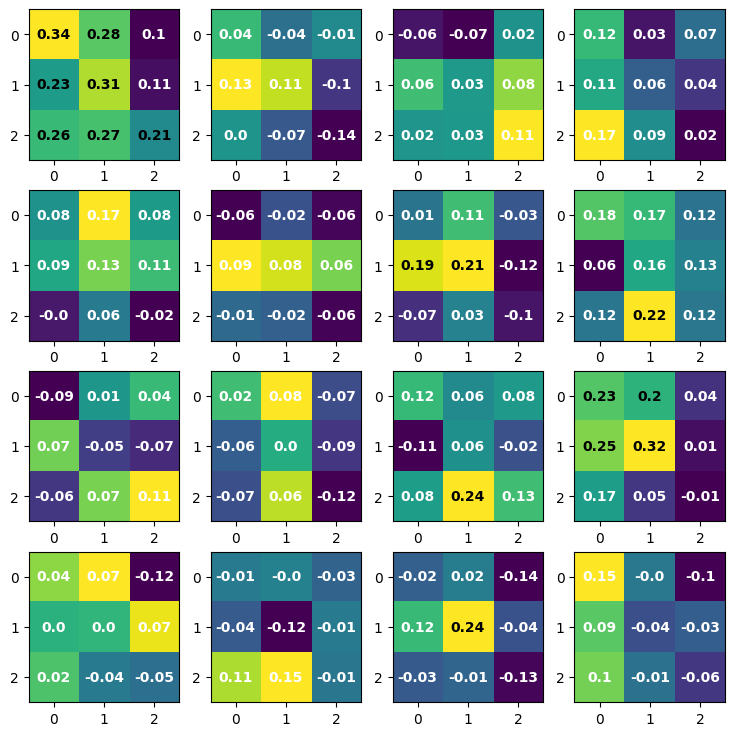

In [16]:
filters , bias = saved_model.layers[6].get_weights()
f_min, f_max = filters.min(), filters.max()
norm_filters = (filters - f_min) / (f_max - f_min)
new_filter_grid(filters, norm_filters, 0, (9,9))

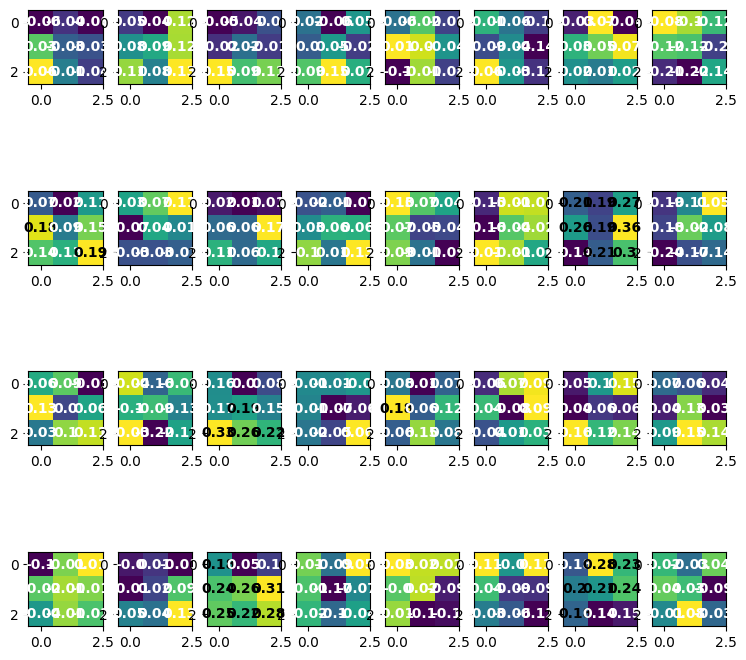

In [17]:
filters , bias = saved_model.layers[10].get_weights()
f_min, f_max = filters.min(), filters.max()
norm_filters = (filters - f_min) / (f_max - f_min)
new_filter_grid(filters, norm_filters, 0, (9,9))